# Build Model

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import copy
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/filtered_data.csv')
df.columns

In [6]:
# One-hot encoding for categorical features
cat_features = ['City', 'Day', 'Room Type']
enc = OneHotEncoder(sparse=False, drop='first')
encoded_features = enc.fit_transform(df[cat_features])
encoded_features_df = pd.DataFrame(encoded_features, columns=enc.get_feature_names_out(cat_features))

# Drop original categorical columns and append encoded features
df = df.drop(cat_features, axis=1)
df = pd.concat([df, encoded_features_df], axis=1)

# Define X and y
X = df.drop('Price', axis=1)
y = df['Price']

# Continue with your existing code from here for splitting data, creating pipelines, and running models


/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=331)

# Define imputers and models
imputers = {
    "simple_imputer": SimpleImputer(strategy="most_frequent"),
    "knn_imputer": KNNImputer()
}
models = {
    "rf": RandomForestRegressor(n_estimators=100, min_samples_leaf=5),
    "lasso": Lasso(),
    "ridge": Ridge()
}

# Create pipelines
pipes = {}
for imputer_name, imputer in imputers.items():
    for model_name, model in models.items():
        pipe = Pipeline(steps=[(imputer_name, imputer), (model_name, model)])
        pipe_name = imputer_name + "+" + model_name
        pipes[pipe_name] = pipe

# Fit pipelines
for pipe_name, pipe in pipes.items():
    pipe.fit(X_train, y_train)

# Define CV parameter grid
cv_param_grid_all = {
    "rf__min_samples_leaf": [1, 3, 5, 10],
    "lasso__alpha": np.logspace(-2, 2, 10),
    "knn_imputer__n_neighbors": [2, 5, 10],
    "ridge__alpha": np.logspace(-3, 7, 10)
}

# Run CV and store results
valid_errs = {}
tuned_pipelines = {}
ypred_valid = {}

for pipe_name, pipe in pipes.items():
    cv_param_grid = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys() if key.startswith(tuple(pipe.named_steps.keys()))}
    pipe_search = GridSearchCV(pipe, cv_param_grid)
    pipe_search.fit(X_train, y_train)
    valid_errs[pipe_name] = pipe_search.score(X_valid, y_valid)
    tuned_pipelines[pipe_name] = copy.deepcopy(pipe_search)
    ypred_valid[pipe_name] = pipe.predict(X_valid)

# Calculate MSE and MAE
summary = pd.DataFrame.from_dict(valid_errs, columns=["Valid Errors"], orient='index')
MSE = [mean_squared_error(y_valid, ypred_valid[col]) for col in ypred_valid]
MAE = [mean_absolute_error(y_valid, ypred_valid[col]) for col in ypred_valid]
summary["MSE"] = MSE
summary["MAE"] = MAE

# Show the summary
print(summary)


                      Valid Errors          MSE        MAE
simple_imputer+rf         0.740893  2952.699590  39.707331
simple_imputer+lasso      0.577548  5089.795800  53.763891
simple_imputer+ridge      0.577711  4135.279585  48.883405
knn_imputer+rf            0.738754  2952.699590  39.707331
knn_imputer+lasso         0.577548  5089.795800  53.763891
knn_imputer+ridge         0.577711  4135.279585  48.883405


Based on the results, the best model seems to be simple_imputer+rf with the highest validation score (0.740893). We will use this model to make predictions on the test data and evaluate its performance using MSE and MAE.

## Test data

In [17]:
best_model_name = 'simple_imputer+rf'
best_model = tuned_pipelines[best_model_name]

# Make predictions on the test data
y_pred_test = best_model.predict(X_test)

# Calculate MSE and MAE for the test data
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

# Print the results
print(f"Test MSE for {best_model_name}: {test_mse}")
print(f"Test MAE for {best_model_name}: {test_mae}")


Test MSE for simple_imputer+rf: 2681.533306098503
Test MAE for simple_imputer+rf: 35.72710922715947


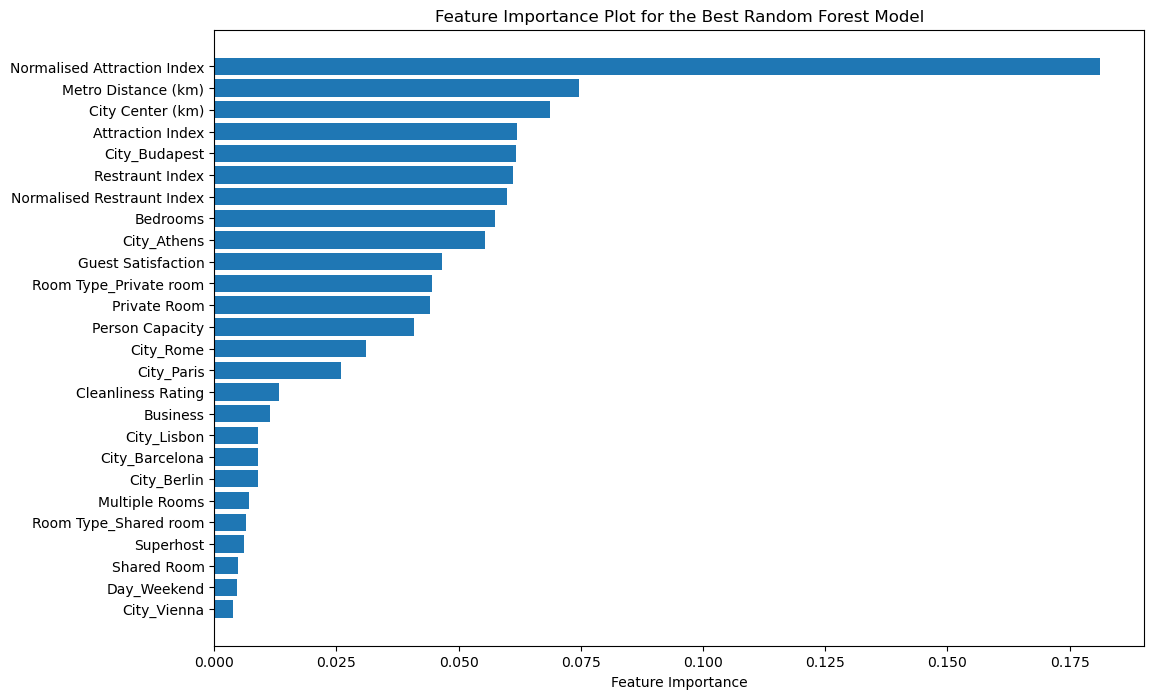

In [23]:
# Extract the best estimator from GridSearchCV and get the Random Forest model
best_rf_model = best_model.best_estimator_.named_steps['rf']

# Extract the feature importances
importances = best_rf_model.feature_importances_

# Get the feature names from the preprocessed dataset
feature_names = X_train.columns

# Sort the importances in descending order and match them with the corresponding feature names
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Create the feature importance plot
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, sorted_importances, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot for the Best Random Forest Model')
plt.gca().invert_yaxis()  # Show the most important features at the top
plt.savefig('figures/feature_importance_plot', bbox_inches='tight')
plt.show()
